In [1]:
import entity
import random
import time
import numpy as np
import pandas as pd
from numerize.numerize import numerize

random.seed(20)
np.random.seed(20)

# Constants for simulation settings
SIMULATION_PERIOD = 300 # Total simulation months
NUMBER_OF_AGENTS = 3000  # Initial number of agents
POPULATION_GROWTH_RATE = 1.00105 # Monthly population growth factor

# Global variables
gdp_timeline = []   # Store GDP over time
agents = []         # List of agents in the economy
agents_len = 0
agents_num_timeline = []
agents_wealth = []  # Store agents' wealth over time
agents_consumption_factor = []
available_jobs = [entity.Farmer(), entity.Retailer(), entity.Driver()]  # Available job types
jobs_incomes = []
goods_data = []     # Store data about goods each month

# Initialize agents at the start of the simulation
def initialize_agents():
    global agents
    global agents_len
    for x in range(NUMBER_OF_AGENTS):
        # agent = entity.Agent(job=random.choice(available_jobs))
        skill_level = 1.0
        if np.random.random() < 0.005:
            skill_level = 2.0
        elif np.random.random() < 0.001:
            skill_level = 2.0
        
        target_job = 0
        if np.random.random() < 0.06:
            target_job = available_jobs[0]
        elif np.random.random() < 0.1:
            target_job = available_jobs[1]
        else:
            target_job = available_jobs[2]
        agent = entity.Agent(skill_level=skill_level, job=target_job)
        agents.append(agent)
        print(agent.id)

    agents_len = len(agents)

# Handle the calculation and logging of GDP
def handle_gdp():
    global gdp_timeline
    gdp_timeline.append(entity.global_gdp)
    entity.global_gdp = 0

# Update goods prices based on demand and supply ratios
def update_goods_prices():
    goods_this_month = {
        'food': 0,
        'goods_c': 0,
        'transport': 0,
        'energy': 0,
        'farmer': 0,
        'retailer': 0,
        'driver': 0,
        'academics': 0,
        'clerk': 0}
        
    for key, goods in entity.all_goods.items():
        goods.update_price()
        entity.update_price_ratio(key, goods)
        goods_this_month[key] = goods.price/goods.original_price
        goods.reset_value()
    return goods_this_month

# Log to file
def log_agent_data(agent, goods_and_jobs):
    if isinstance(agent.job, entity.Farmer):
        goods_and_jobs['farmer'] += 1   
    elif isinstance(agent.job, entity.Retailer):
        goods_and_jobs['retailer'] += 1
    elif isinstance(agent.job, entity.Driver):
        goods_and_jobs['driver'] += 1
    elif isinstance(agent.job, entity.Academics):
        goods_and_jobs['academics'] += 1
    elif isinstance(agent.job, entity.Clerk):
        goods_and_jobs['clerk'] += 1
    
# Update agent activities, consumption, and record wealth
def update_agents(goods_and_jobs):
    global agents_len
    global agent_wealth
    global agents_consumption_factor
    agent_wealth = []
    agent_cons_factor = []
    for i, agent in enumerate(agents):
        agent.update()        
        agent_wealth.append(agent.wealth)
        
        # Track the number of agents in each job type for this month
        log_agent_data(agent, goods_and_jobs)
        agent_cons_factor.append(agent.consumption_factor)
   
    agents_wealth.append(agent_wealth) 
    agents_consumption_factor.append(np.mean(agent_cons_factor))
    goods_data.append(goods_and_jobs)
    agents_num_timeline.append(len(agents))

# Handle population growth by adding new agents
def handle_population_growth():
    global agents_len
    agents_len *= POPULATION_GROWTH_RATE
    needed_agent = round(agents_len-len(agents))
    if needed_agent >= 1:
        for x in range(needed_agent):
            job = np.random.random()
            if job < 0.06:
                job = entity.Farmer()
            elif job < 0.6:
                job = entity.Retailer()
            else:
                job = entity.Driver()
            agent = entity.Agent(job=random.choice(available_jobs))
            agents.append(agent)

def log_job_data():
    incomes = [
        entity.FARMER_OUTPUT_FOOD * entity.all_goods['food'].price,
        entity.RETAILER_OUTPUT_GOODS * entity.all_goods['goods_c'].price,
        entity.DRIVER_OUTPUT_TRANSPORT * entity.all_goods['transport'].price,
    ]
    jobs_incomes.append(incomes)


# Main simulation loop
def main():
    global agents
    global agents_len

    # Iterate through the simulation period
    for _ in range(SIMULATION_PERIOD):
        handle_gdp()        
        goods_this_month = update_goods_prices()
        update_agents(goods_this_month) # this variable is passed just for logging
        handle_population_growth()
        log_job_data()
        entity.update_level_1_jobs()
        # print(entity.level_1_jobs)
        if _ % 10 == 0:
            print(f"Month: {_}")
            # print(entity.level_1_jobs)
        # time.sleep(0.1)

if __name__ == "__main__":
    initialize_agents()
    main()
    data = pd.DataFrame(goods_data)
    data['agents'] = agents_num_timeline
    data['gdp'] = gdp_timeline
    data['total_wealth'] = [sum(x) for x in agents_wealth]
    data['avg_cons_fac'] = agents_consumption_factor
    data = pd.concat([data, pd.DataFrame(jobs_incomes, columns=['farmer', 'retailer', 'driver'])], axis=1)
    data['wealth_per_capita'] = data['total_wealth']/data['agents']
    # print(data)
    # print([{x.id: x.wealth} for x in agents])
    data.to_excel('goods.xlsx')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<Axes: >

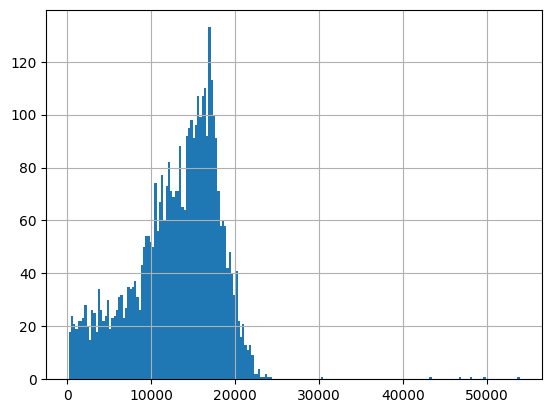

In [3]:
wealths = [{'id': x.id, 'wealth': x.wealth, 'job': x.job.title, 'income': x.job.income, 'outcome': x.latest_spending, 'edu': x.skill_level, 'cons': x.consumption['food'], 'cons_f': x.consumption_factor} for x in agents]
wealths = pd.DataFrame(wealths).sort_values(by='wealth', ascending=False).reset_index()
# wealths[wealths['job']=='Academics'].count()
wealths.to_excel('agent.xlsx')
wealths['wealth'].hist(bins=200)

<Axes: >

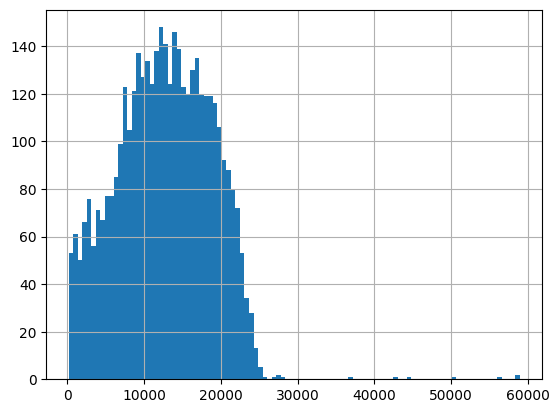

In [15]:
wealths['wealth'].hist(bins=100)